In [1]:
import pandas as pd
import numpy as np
import matplotlib.dates as md
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from pyemma import msm
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Prophet setting
import fbprophet
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)

import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )
import os
import sys
from glob import glob 
%matplotlib inline

In [2]:
# Customized Functions
import utilities as utils
import dash_func

In [3]:
from scipy.fftpack import dct, idct

In [235]:
pd_df.to_pickle('random_ts.pkl')

In [4]:
# read data and parse the date column
pd_df = pd.read_pickle('random_ts.pkl')
# drop off duplications
pd_no_dup = pd_df.drop_duplicates()

### Data Preprocessing: Using Prediction Model to Approximate the Behavirors of the Time Series
The key idea using prediction is that the predict can be thought as the principle features of the time series, which could be used as featurse for later clustering method. Besides, the prediction model can also handle missing data, thus, data length is guranteed to be the same after this pre-processing.

In [5]:
# data pre-processing
countries = list(pd_no_dup.Country.unique())
platforms = list(pd_no_dup.Platform.unique())
metric = 'TRU'
platform = ['Android(All)']
test_time = '2020-03-08'
y_hat = []
for country in countries:
    # get filtered data
    filteres = [{'Country':[country]},{'Platform':platform}]
    bool_mask, attrs = dash_func.get_filtered_data(pd_no_dup, filteres)
    pd_raw = pd_no_dup[bool_mask[0]]
    pd_raw.sort_index(inplace=True)
    pd_raw.head()
    #2018-03-15  2020-03-09
    df_date = pd.date_range(start='3/15/2018', end='3/09/2020').to_frame()
    df_date = df_date.rename(columns={0:'ds'})
    pd_date = pd.merge(df_date,pd_raw,how='left',left_index=True,right_index=True)
    data = pd_date[metric]
    data = data.to_frame()
    data = data.rename(columns={'TRU':'y'})
    data_train, data_test = utils.prepare_data(data, test_time)
    data_train = data_train.rename(columns={'index':'ds'})
    data_test = data_test.rename(columns={'index':'ds'})
    Prophet = fbprophet.Prophet
    m = Prophet(#mcmc_samples=300, 
            #growth='logistic',
            changepoint_prior_scale=0.05,
            changepoint_range=1.0,
            interval_width=0.90,
            #seasonality_mode='multiplicative', \
            yearly_seasonality='auto', \
            weekly_seasonality='auto', \
            daily_seasonality='auto',
           )
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    m.fit(data_train)
    future = m.make_future_dataframe(periods=len(data_test), freq='1D')
    forecast = m.predict(future)
    verif = utils.make_verif(forecast, data_train, data_test)
    y_hat.append(verif[['y','yhat','yhat_upper','yhat_lower']].to_numpy())

### Use DCT to Extract Features 

In [85]:
def dct2(x):
    return dct(dct(x,norm = 'ortho' ).T, norm = 'ortho').T

In [46]:
data = [y[:,1] for y in y_hat]
data_scaled = []
for d in data:
    d = d.reshape(-1,1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(d)
    data_scaled.append(scaler.transform(d))

In [86]:
dct_coeff = []
for d in data_scaled:
    dct_coeff.append(dct2(d))

In [87]:
# Reshaple the dct_coeff
dct_coeff1 = np.array(dct_coeff).reshape(len(dct_coeff),len(dct_coeff[0]))

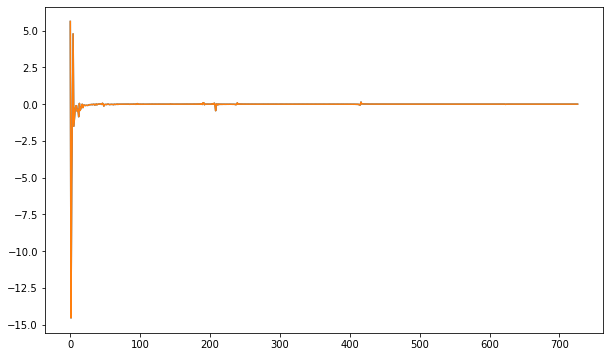

In [88]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(dct_coeff[0])
ax.plot(dct_coeff1[0])

### check IDCT and original data

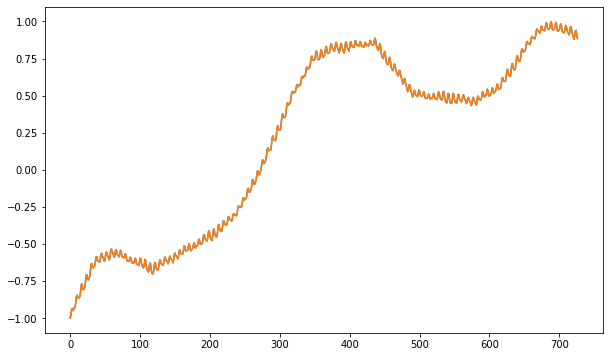

In [96]:
recovery = idct(dct_coeff1[0], norm = 'ortho')
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(recovery)
ax.plot(data_scaled[0])

### Perform the Elbow Curve to Selecte Number of Clusters

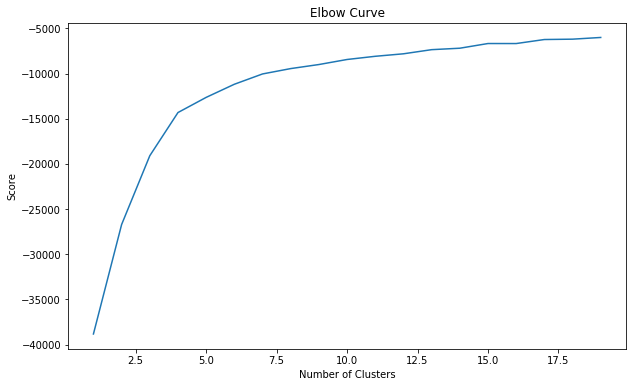

In [97]:
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(dct_coeff1) for i in n_cluster]
scores = [kmeans[i].score(dct_coeff1) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

### 10 is Chosen as the number of Centroid

In [184]:
km = KMeans(n_clusters=10)
km.fit(dct_coeff1)
km.predict(dct_coeff1)
labels = km.labels_

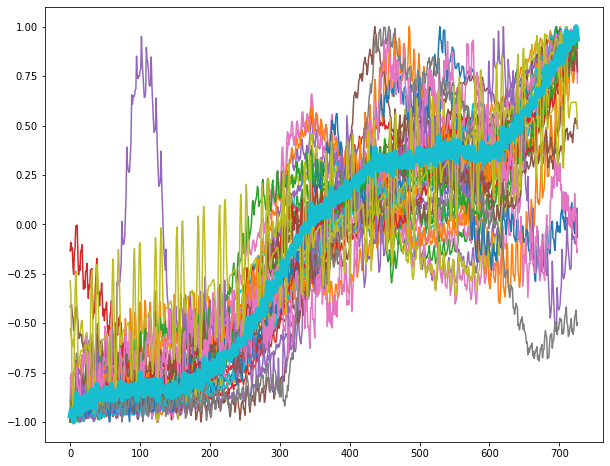

In [185]:
# plot original clustered data
fig = plt.figure(figsize=[10,8])
label = 8
for index, l in enumerate(labels):
    if l == label:
        y_reshape = data[index].reshape(-1,1)
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaler = scaler.fit(y_reshape)
        y_scaled = scaler.transform(y_reshape)
        plt.plot(y_scaled) 
centroid = idct(km.cluster_centers_[label].T, norm = 'ortho')
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(centroid.reshape(-1,1))
centroid_scaled = scaler.transform(centroid.reshape(-1,1))
plt.plot(centroid_scaled,lw=5)
plt.show()

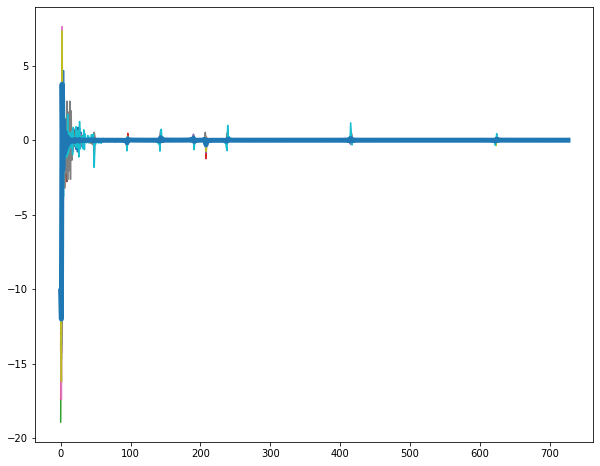

In [186]:
# Plot the coeff and the km_centroid
fig = plt.figure(figsize=[10,8])
label = 0
for index, l in enumerate(labels):
    if l == label:
        y_reshape =  dct_coeff[index].reshape(-1,1)
        plt.plot(y_reshape) 
centroid = km.cluster_centers_[label].reshape(-1,1)
plt.plot(centroid,lw=5)
plt.show()

### Calculate the distance of each time series to the centorid

In [119]:
def getDistanceByPoint(data, model):
    '''
    calculate distance to k-mean centroid
    --------
    params
    data: list of features
    model: kmean model
    ----------
    return:
    distance: list of distance
    '''
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.sqrt(np.mean((Xa-Xb)**2)))
    return distance

In [120]:
distance = getDistanceByPoint(dct_coeff1, km)

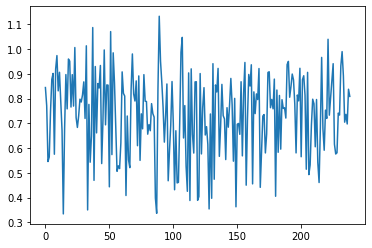

In [121]:
plt.plot(distance)

### Get outliers based on distance
* assume Gaussian and 2 sigma rule
* Isolation forest
* SVM
* KNN

### Gasussian Assumptions

In [182]:
def plot_dct(dct_coeff, outlier_mask, labels,label, km):
    # Plot the outlier coeff and the km_centroid
    fig = plt.figure(figsize=[10,8])
    i = 0
    for index, l in enumerate(labels):
        if l == label:
            i += 1
            if outlier_mask[i-1] == True:
                y_reshape =  dct_coeff[index].reshape(-1,1)
                #scaler = MinMaxScaler(feature_range=(-1, 1))
                #scaler = scaler.fit(y_reshape)
                #y_scaled = scaler.transform(y_reshape)
                plt.plot(y_reshape) 
    centroid = km.cluster_centers_[label].reshape(-1,1)
    #scaler = MinMaxScaler(feature_range=(-1, 1))
    #scaler = scaler.fit(centroid)
    #centroid_scaled = scaler.transform(centroid)
    plt.plot(centroid,lw=5)
    plt.title(f'labels:{label}')
    plt.show()
    
def plot_ts(data, outlier_mask, labels,label, km):
    # Plot the outlier coeff and the km_centroid
    fig = plt.figure(figsize=[10,8])
    i = 0
    for index, l in enumerate(labels):
        if l == label:
            i += 1
            if outlier_mask[i-1] == True:
                y_reshape =  data[index]
                #scaler = MinMaxScaler(feature_range=(-1, 1))
                #scaler = scaler.fit(y_reshape)
                #y_scaled = scaler.transform(y_reshape)
                plt.plot(y_reshape) 
    centroid = idct(km.cluster_centers_[label].T, norm = 'ortho')
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(centroid.reshape(-1,1))
    centroid_scaled = scaler.transform(centroid.reshape(-1,1))
    plt.title(f'labels:{label}')
    plt.plot(centroid_scaled,lw=5)
    plt.show()
    
def plot_ts_pca(data, outlier_mask, labels,label, km, pca):
    # Plot the outlier coeff and the km_centroid
    fig = plt.figure(figsize=[10,8])
    i = 0
    for index, l in enumerate(labels):
        if l == label:
            i += 1
            if outlier_mask[i-1] == True:
                y_reshape =  data[index]
                #scaler = MinMaxScaler(feature_range=(-1, 1))
                #scaler = scaler.fit(y_reshape)
                #y_scaled = scaler.transform(y_reshape)
                plt.plot(y_reshape) 
    centroid = idct(pca.inverse_transform(km.cluster_centers_[label]).T, norm = 'ortho')
    plt.title(f'labels:{label}')
    plt.plot(centroid,lw=5)
    plt.show()

#### Visulize the outlier based on 3 sigma rule of the calculated distance

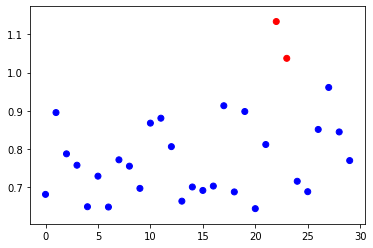

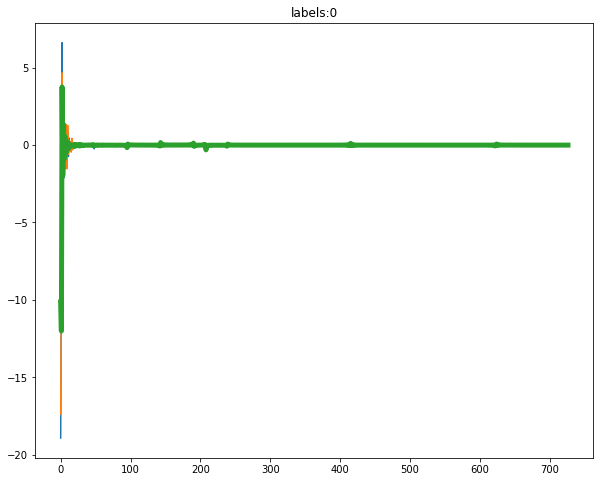

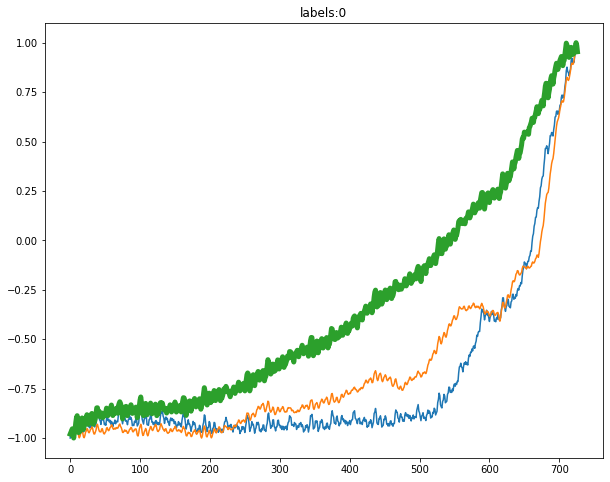

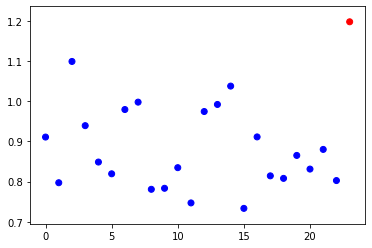

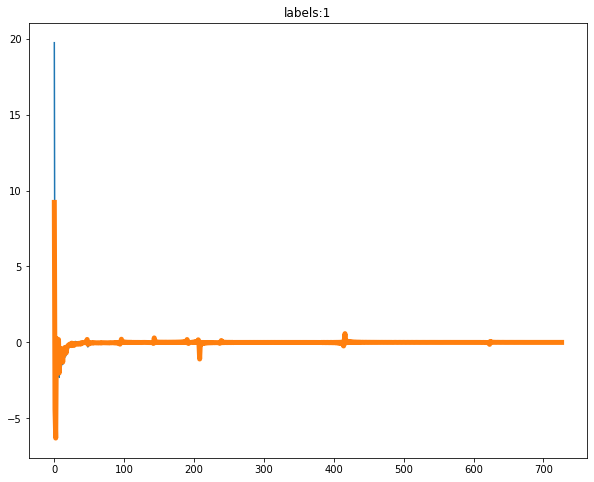

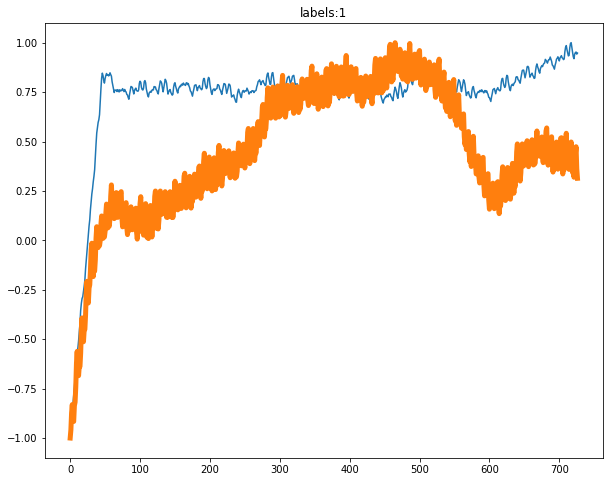

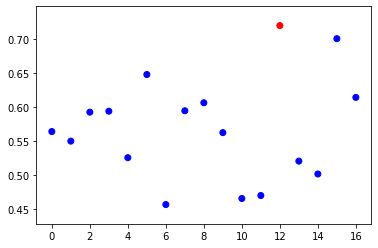

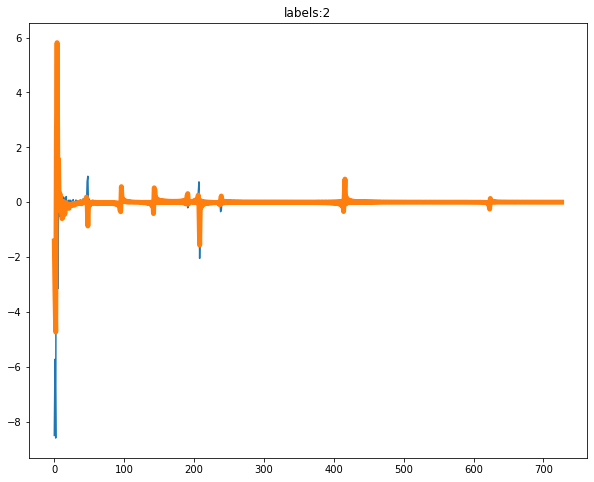

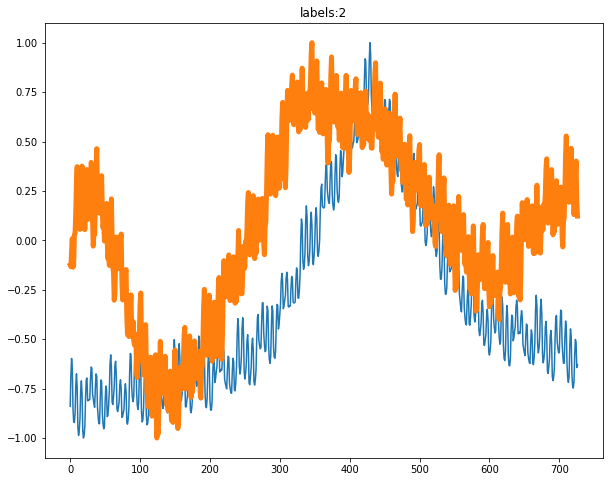

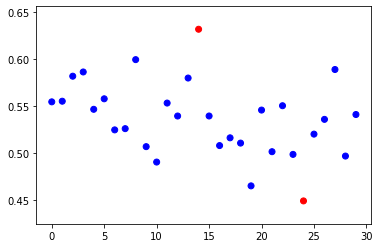

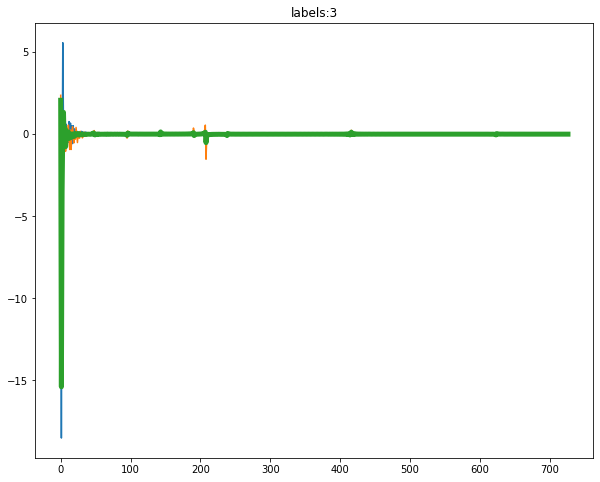

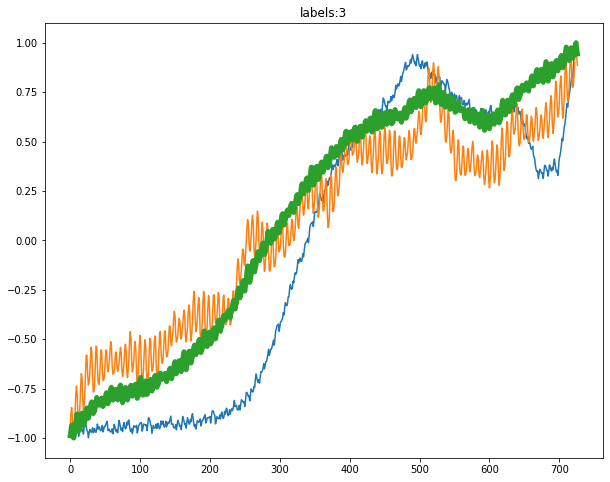

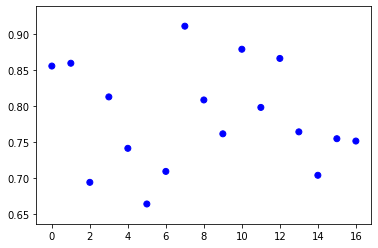

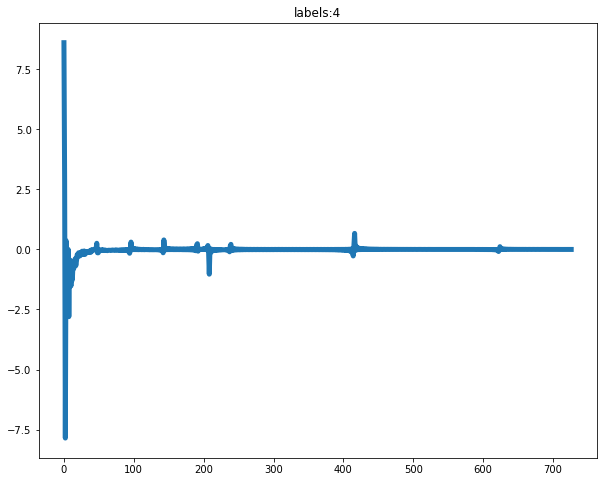

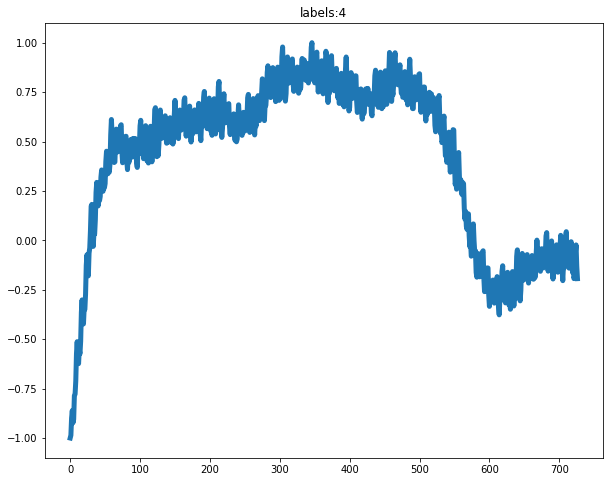

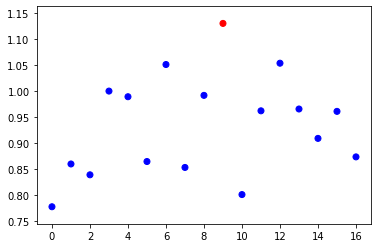

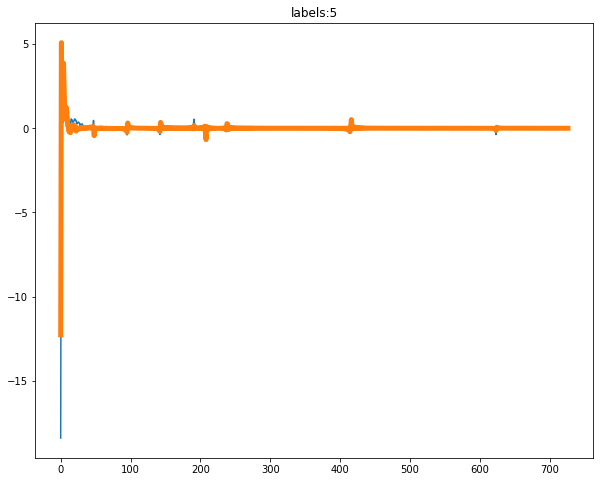

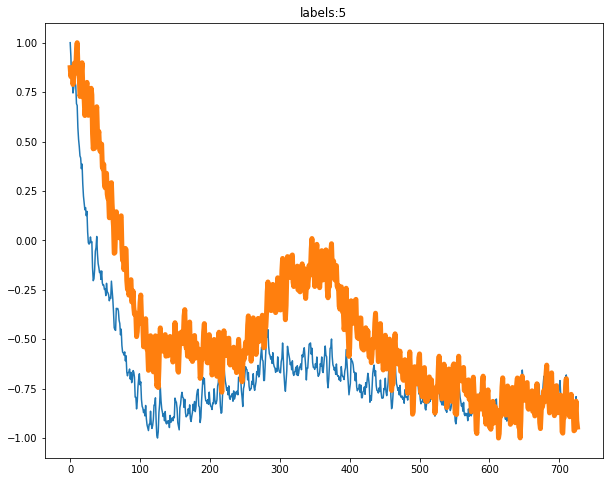

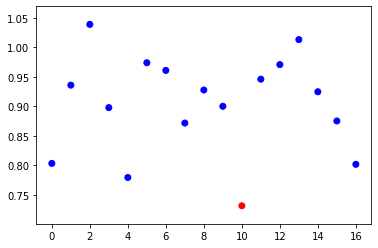

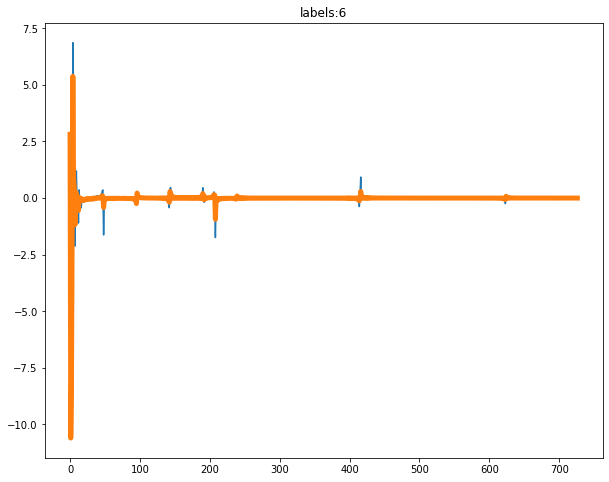

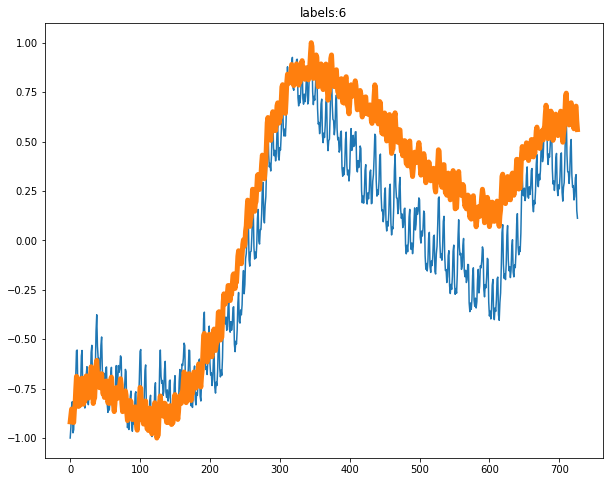

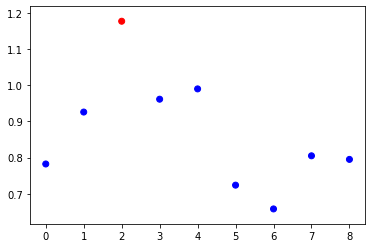

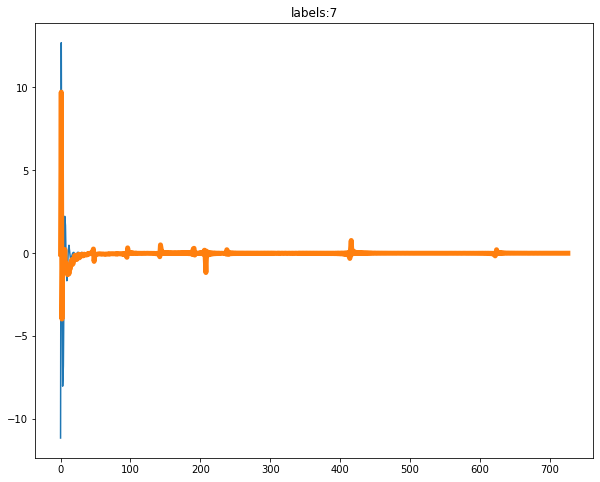

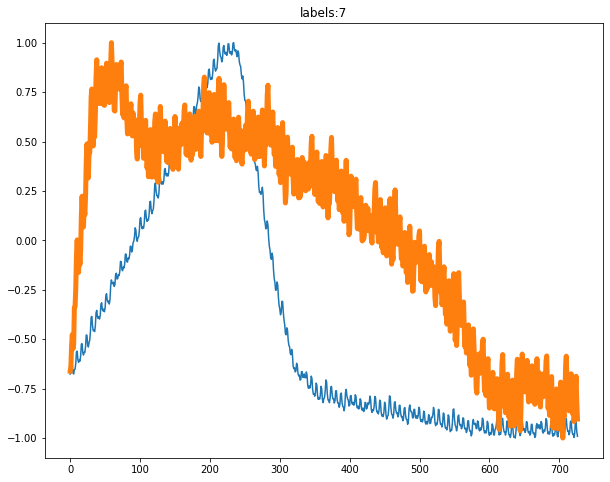

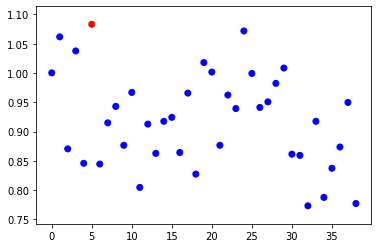

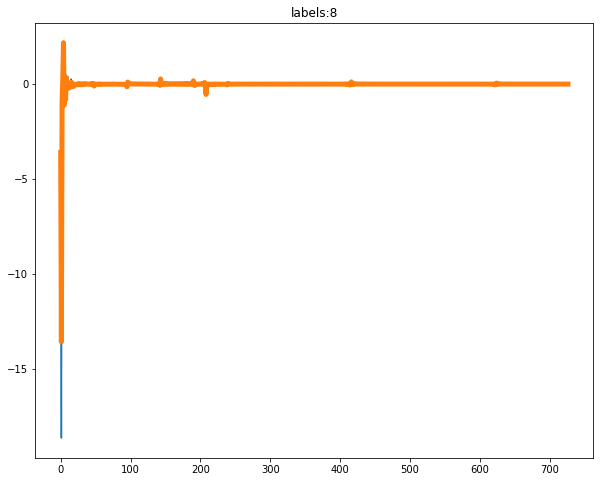

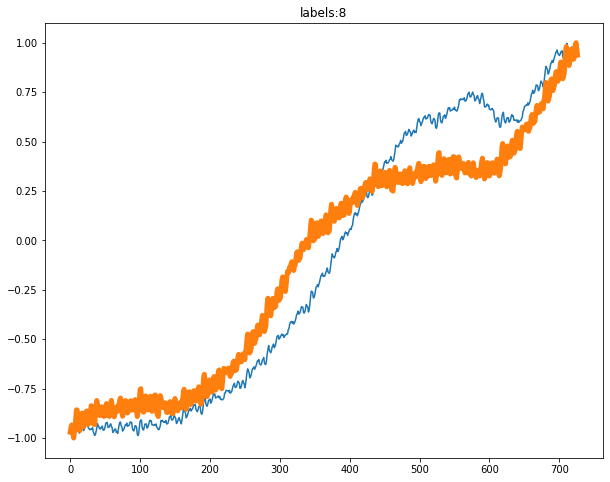

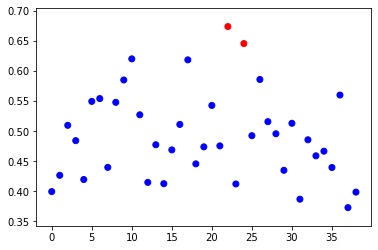

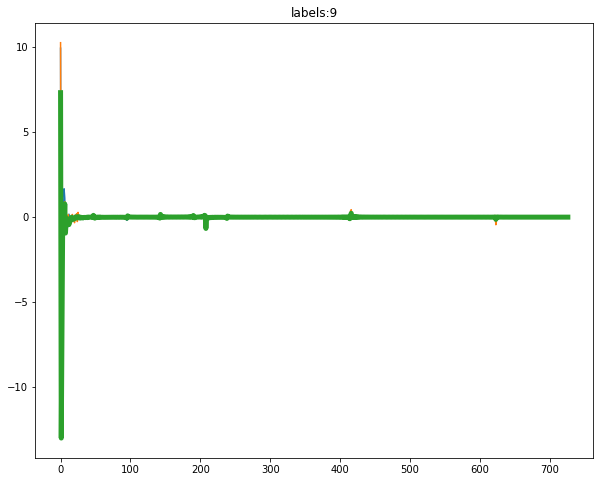

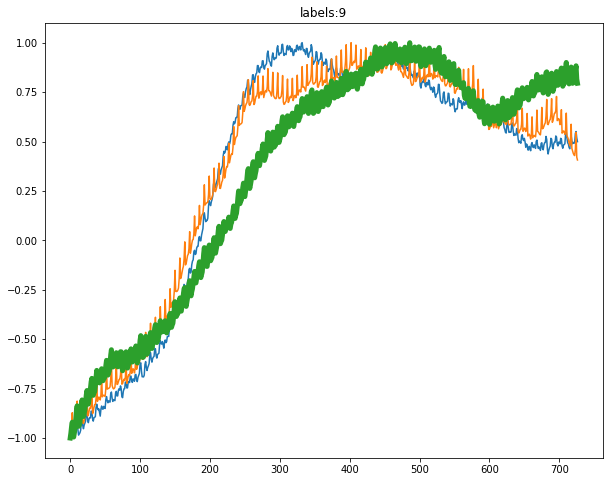

In [187]:
distance = getDistanceByPoint(dct_coeff1, km)
# Asumme Gaussain
num_sig = 2
for label in range(max(labels)+1):
    # select distance with same label
    distance_label = [distance[i] for i, v  in enumerate(labels) if v==label ]
    sig = np.std(distance_label)
    # generate outlier mask
    outlier_mask = abs((np.array(distance_label)-np.mean(distance_label))) > num_sig*sig 

    # visulize the outliers in the distance domain
    colors = {0:'blue', 1:'red'}
    color = []
    for m in outlier_mask:
        color.append(colors[m])
    plt.scatter(range(len(distance_label)),distance_label, c = color)
    plot_dct(dct_coeff, outlier_mask, labels, label, km)
    plot_ts(data_scaled, outlier_mask, labels, label, km)

### Test PCA
* PCA can significantly reduce the feature space, thus speed up the process

#### Calculate the variance vs. components => help determine how many principle components are needed

/Users/ningxin/opt/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:796: ComplexWarning:

Casting complex values to real discards the imaginary part

/Users/ningxin/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning:

Casting complex values to real discards the imaginary part

/Users/ningxin/opt/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:796: ComplexWarning:

Casting complex values to real discards the imaginary part



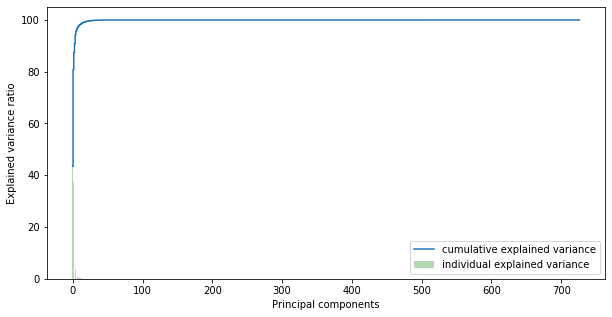

In [127]:
#'''
# Calculate the variance vs. components => help determine how many principle components are needed
#'''
cov_mat = np.cov(np.array(data_scaled).reshape(len(data),-1).T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

#### 50 principle components are selected

In [170]:
pca = PCA(n_components=50)
pca.fit(np.array(dct_coeff1).reshape(len(data),-1))

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [171]:
pca_feature = pca.transform(np.array(dct_coeff1).reshape(len(data),-1))

In [172]:
len(pca_feature), len(pca_feature[0])

(239, 50)

## Perform the Elbow Curve to Selecte Number of Clusters

Text(0.5, 1.0, 'Elbo')

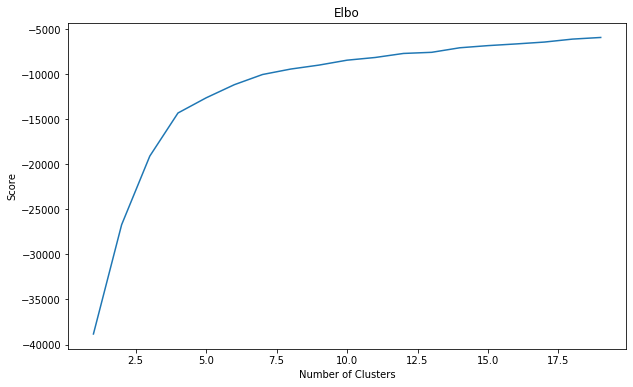

In [173]:
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(pca_feature) for i in n_cluster]
scores = [kmeans[i].score(pca_feature) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbo')

#### 10 clusters are chosen

In [174]:
km_pca = KMeans(n_clusters=10)
km_pca.fit(pca_feature)
km_pca.predict(pca_feature)
labels_pca = km_pca.labels_

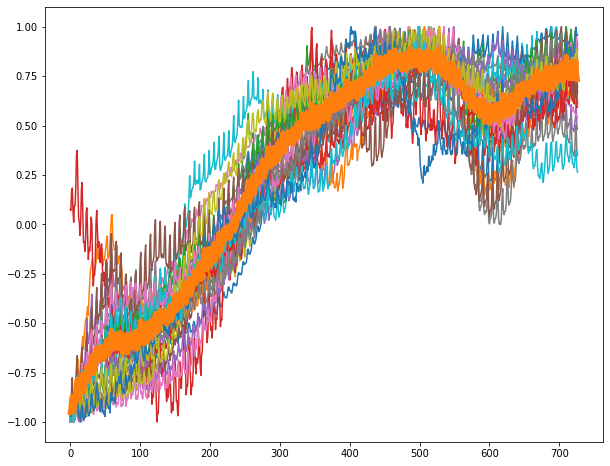

In [207]:
# plot original clustered data
fig = plt.figure(figsize=[10,8])
label = 5
for index, l in enumerate(labels_pca):
    if l == label:
        y_reshape = data[index].reshape(-1,1)
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaler = scaler.fit(y_reshape)
        y_scaled = scaler.transform(y_reshape)
        plt.plot(y_scaled) 
centroid = idct(pca.inverse_transform(km_pca.cluster_centers_[label]).T, norm='ortho')
plt.plot(centroid,lw=5,label='centroid')
plt.show()

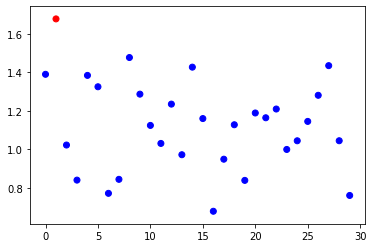

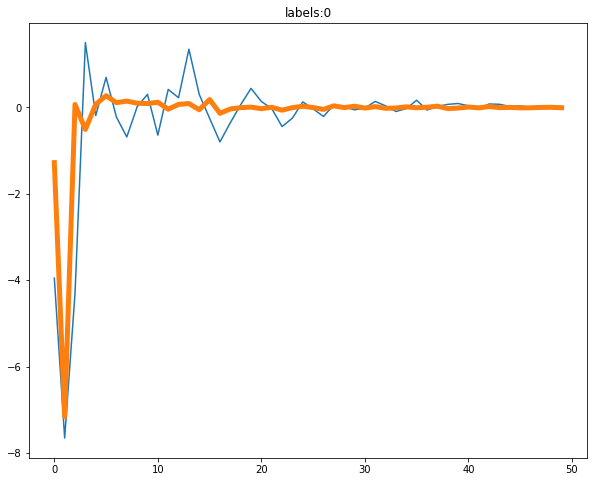

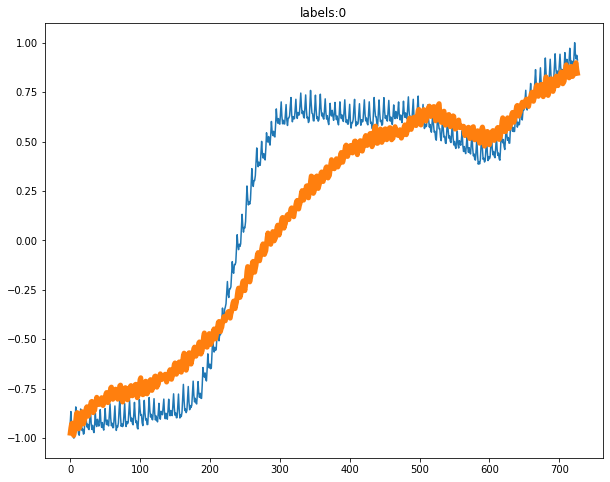

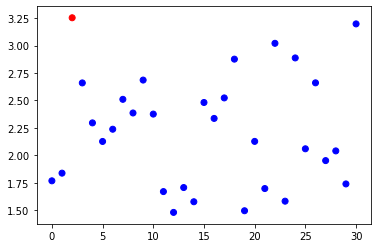

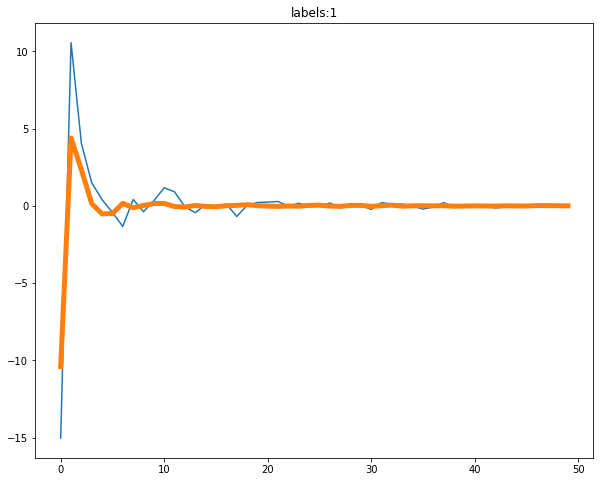

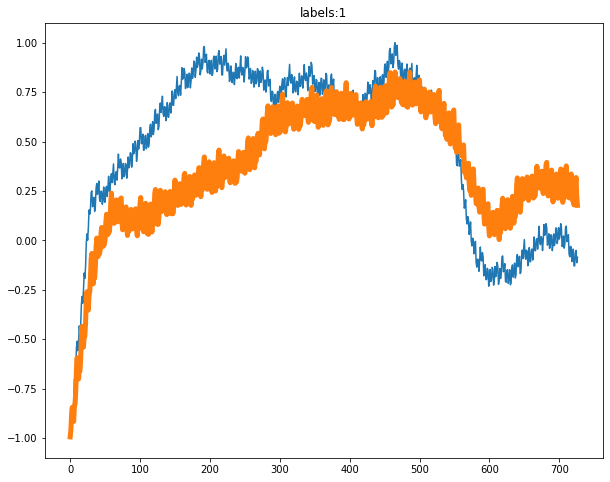

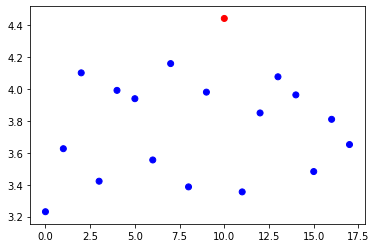

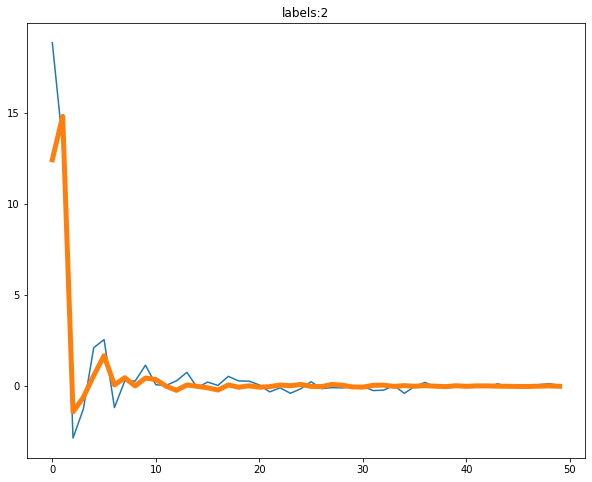

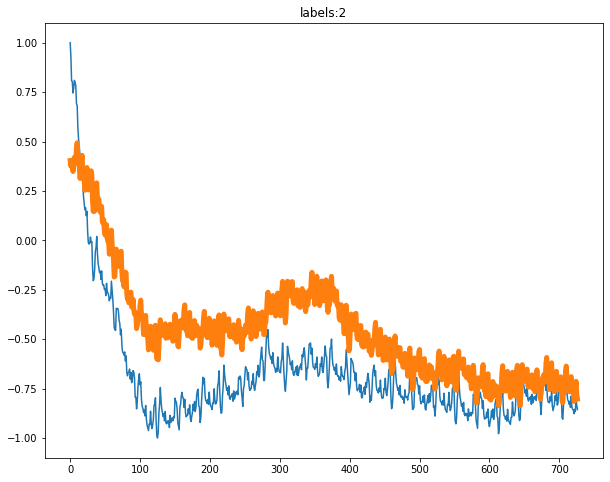

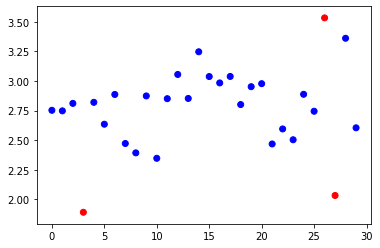

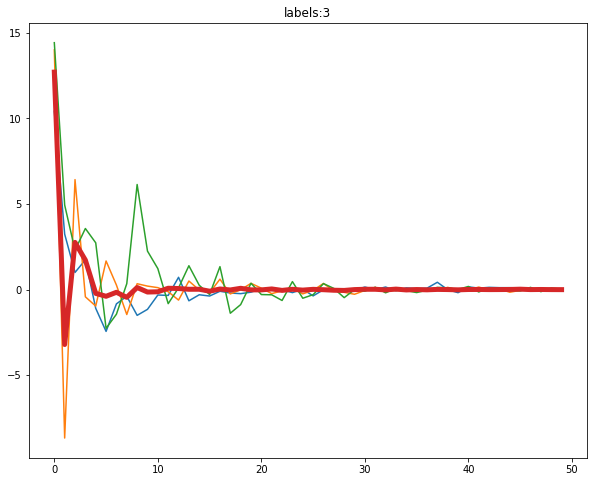

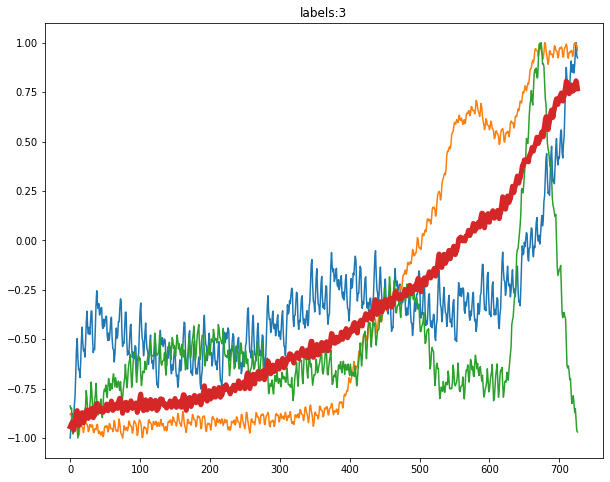

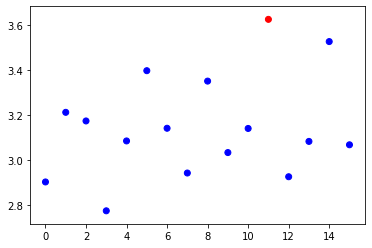

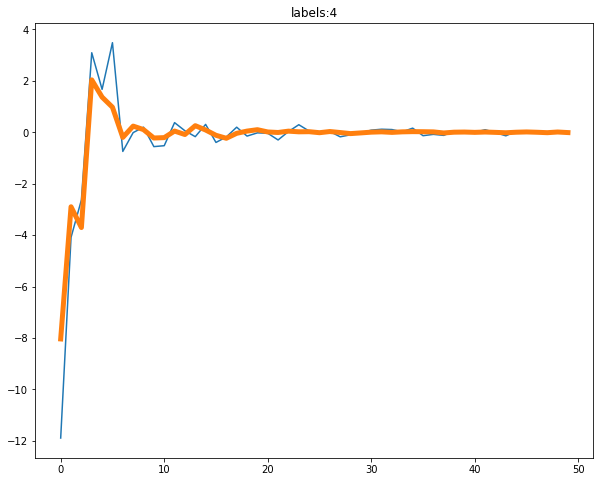

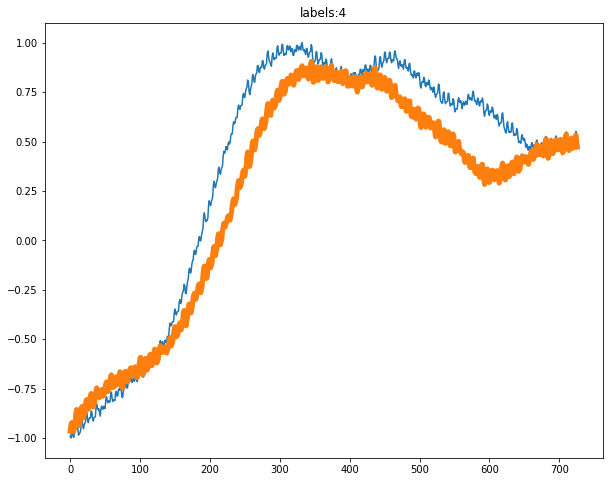

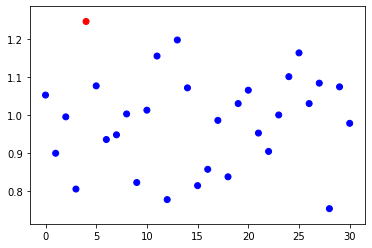

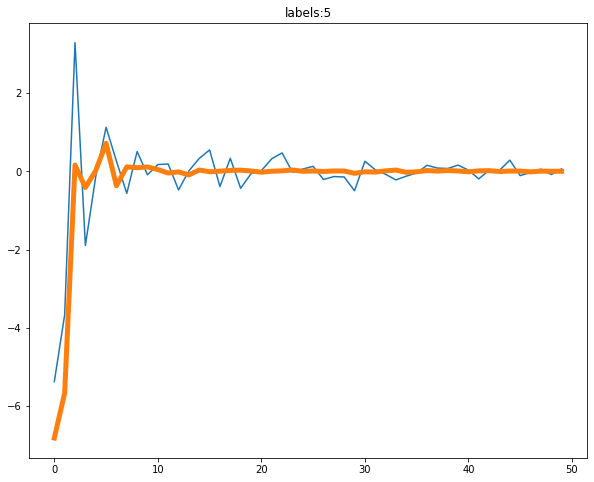

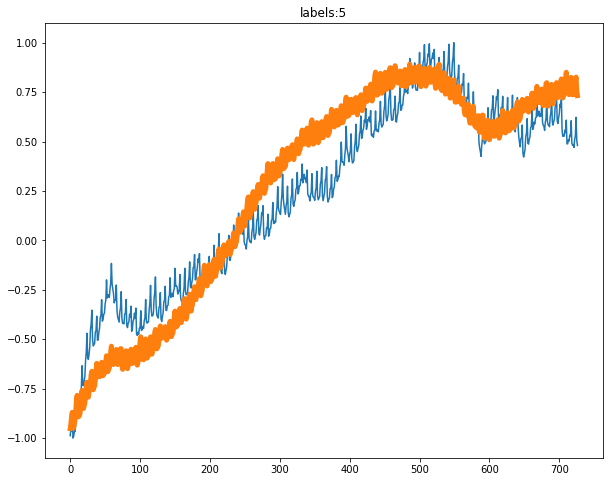

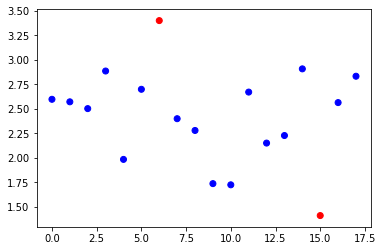

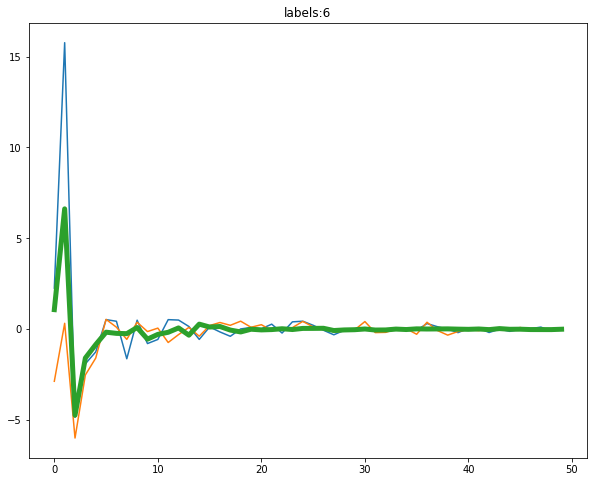

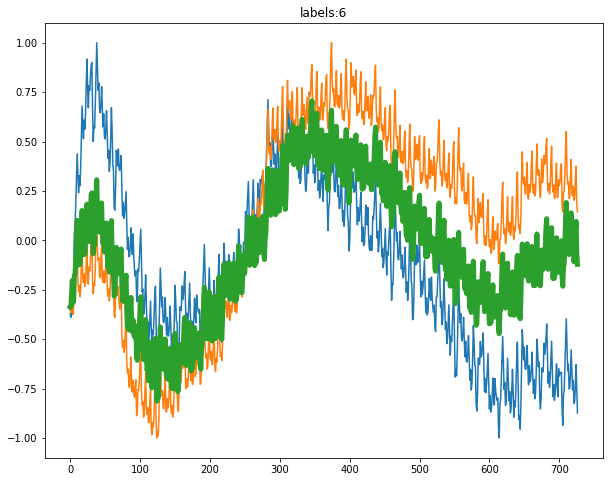

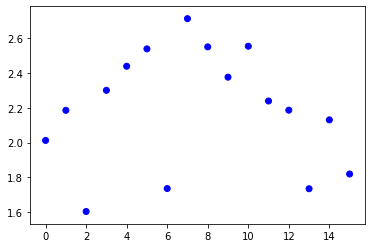

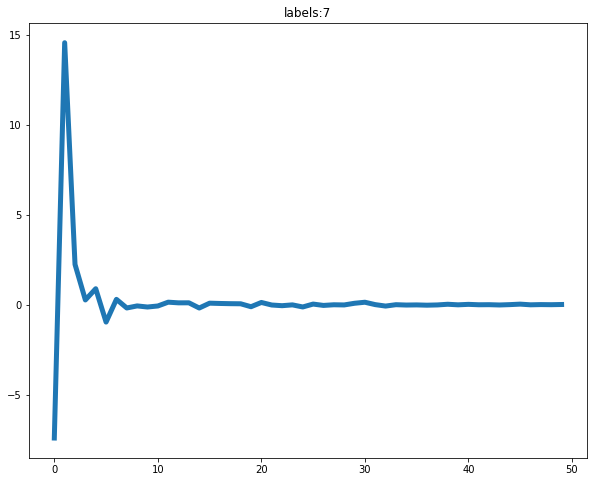

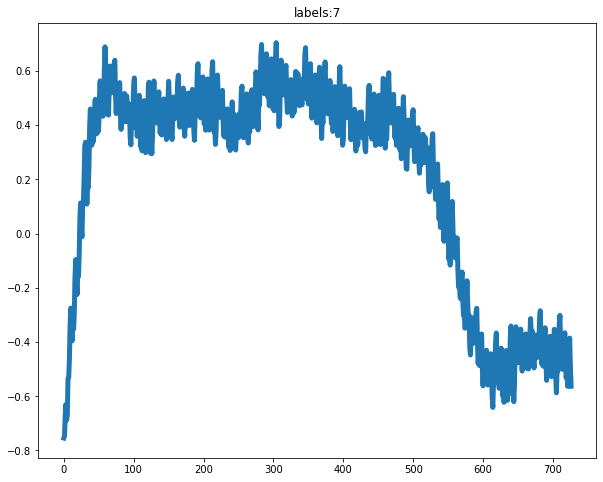

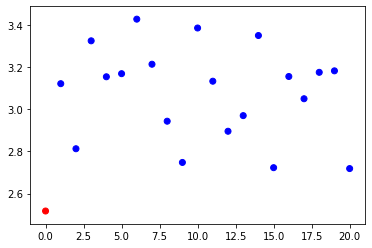

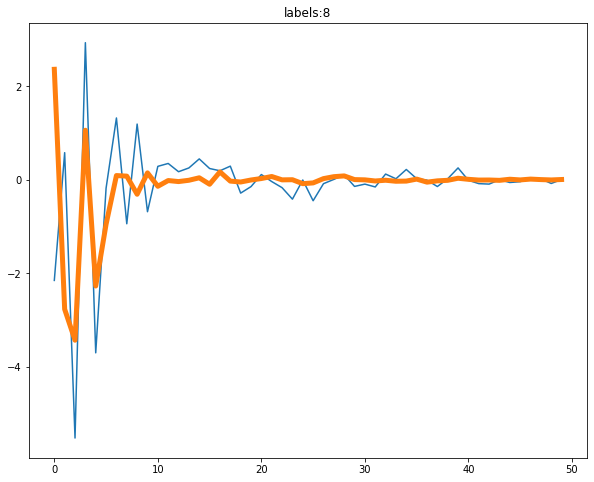

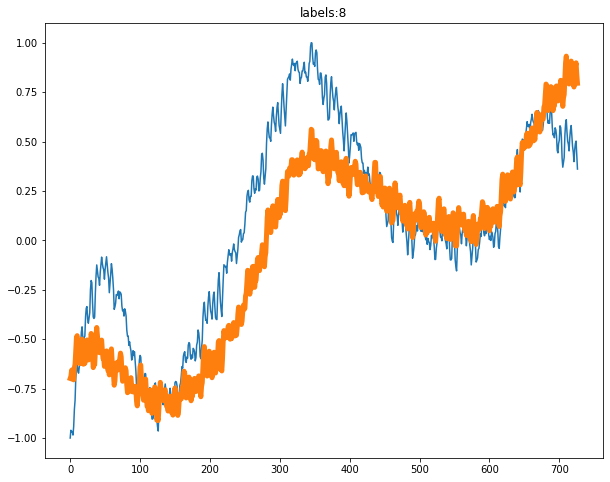

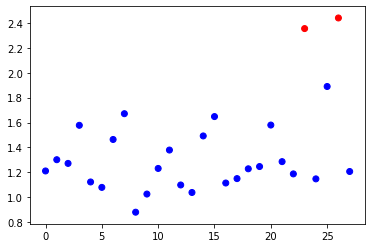

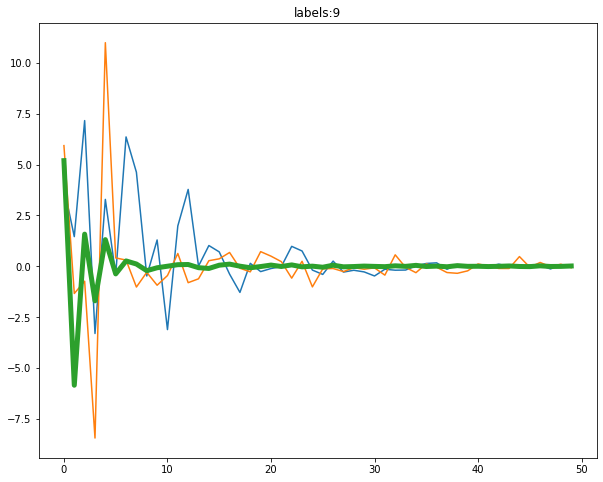

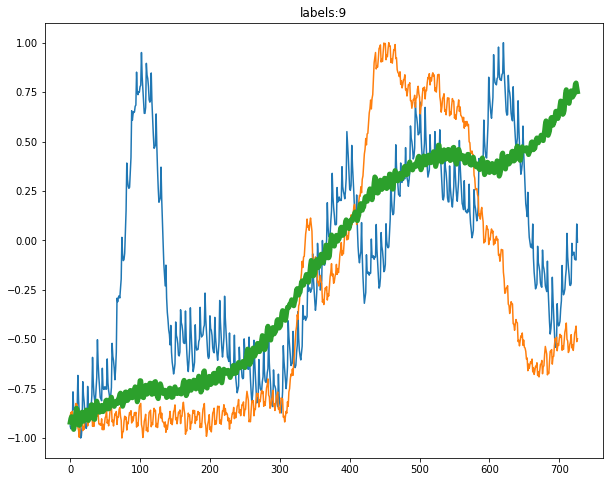

In [183]:
distance_pca = getDistanceByPoint(pca_feature, km_pca)
# Asumme Gaussain
num_sig = 2
# plot the calculated distance and identity the outlier using 3 sigma rule
# also plot the pca features and original time series
for label in range(max(labels_pca)+1):
    # select distance with same label
    distance_label = [distance_pca[i] for i, v  in enumerate(labels_pca) if v==label ]
    sig = np.std(distance_label)
    # generate outlier mask
    outlier_mask = abs((np.array(distance_label)-np.mean(distance_label))) > num_sig*sig 

    # visulize the outliers in the distance domain
    colors = {0:'blue', 1:'red'}
    color = []
    for m in outlier_mask:
        color.append(colors[m])
    plt.scatter(range(len(distance_label)),distance_label, c = color)
    plot_dct(pca_feature, outlier_mask, labels_pca, label, km_pca)
    plot_ts_pca(data_scaled, outlier_mask, labels_pca, label, km_pca, pca)

### visulization in 2 main features

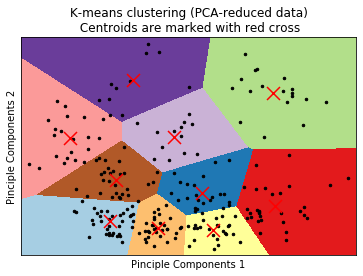

In [204]:
# Visualize the results on PCA-reduced data
reduced_data = PCA(n_components=2).fit_transform(pca_feature)
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10)
kmeans.fit(reduced_data)
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = pca_feature[:, 0].min() - 1, pca_feature[:, 0].max() + 1
y_min, y_max = pca_feature[:, 1].min() - 1, pca_feature[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(1)
plt.clf()

plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(pca_feature[:,0], pca_feature[:, 1], 'k.', markersize=5)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='r', zorder=10)
plt.title('K-means clustering (PCA-reduced data)\n Centroids are marked with red cross')
plt.xlabel('Pinciple Components 1')
plt.ylabel('Pinciple Components 2')
plt.xticks(())
plt.yticks(())
plt.show()

## Isolation Forest Based Outlier Detections

In [222]:
df_data.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,anomaly1
0,-4.749835,-6.683470,-2.339877,-0.295799,-2.019964,-1.536173,0.987033,1.622835,0.430402,-0.418353,...,-0.019331,-0.067170,-0.034135,0.027915,-0.012609,0.023441,0.038331,0.005578,0.051383,1
1,0.342479,8.687108,-3.700221,-7.358535,-1.334732,-1.159885,-1.526904,0.616248,-0.990653,0.277120,...,-0.218040,0.071578,0.021957,0.041449,0.037016,-0.013477,0.018177,-0.026678,0.004900,1
2,-11.556505,-0.571360,2.175499,-0.408700,-1.035968,0.355090,-0.049385,-0.317371,0.011798,0.242761,...,0.049099,-0.002519,0.007130,-0.042057,0.026077,0.109380,0.021902,-0.014296,0.061660,1
3,-2.153840,0.581770,-5.528725,2.936542,-3.704399,-0.178931,1.324837,-0.940811,1.193878,-0.682679,...,-0.081556,-0.091419,0.001680,-0.057254,-0.039765,0.036047,0.019789,-0.077813,0.006609,1
4,-6.268956,-4.632554,0.990182,-1.089566,0.802084,0.544233,-0.526792,-0.474728,-0.063434,0.508912,...,0.058732,0.009492,0.082905,-0.001966,0.167059,-0.074171,0.040929,0.074791,-0.018843,1


Anomaly IndexInt64Index([188, 190, 193, 197, 208, 214, 215, 218, 219, 227, 230, 236], dtype='int64')


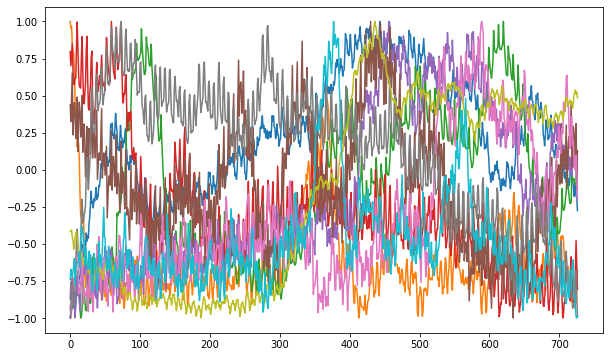

In [242]:
outliers_fraction = 0.05#'auto'#0.05
df_data = pd.DataFrame(pca_feature)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(df_data) 
df_data['anomaly1'] = pd.Series(model.predict(df_data))
# visualization
a = df_data.loc[df_data['anomaly1'] == -1] #anomaly
index_anomaly = a.index
print(f'Anomaly Index{index_anomaly}')
num_anomaly_plot = np.random.choice(range(len(index_anomaly)),size = 10, replace = False)
fig, ax = plt.subplots(figsize=(10,6))
for i in num_anomaly_plot:   
    ax.plot(data_scaled[index_anomaly[i]])
plt.show()

### SVM Based Anomaly Detections

In [238]:
df_data = pd.DataFrame(pca_feature)
model = OneClassSVM(nu=0.05, kernel="rbf", gamma=0.01)
model.fit(df_data)
df_data['anomaly2'] = pd.Series(model.predict(df_data))

Anomaly IndexInt64Index([  1,  20,  27,  28,  37,  40,  51,  61,  64, 100, 122, 125, 127,
            132, 140, 144, 156, 158, 167, 181, 193, 208, 214, 216, 219, 227,
            232, 236],
           dtype='int64')


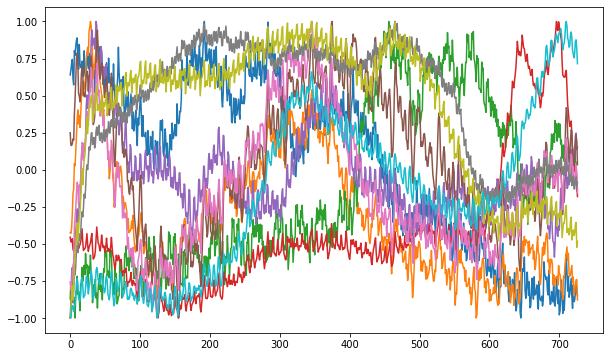

In [240]:
# visualization
a = df_data.loc[df_data['anomaly2'] == -1] #anomaly
index_anomaly = a.index
print(f'Anomaly Index{index_anomaly}')
num_anomaly_plot = np.random.choice(range(len(indbex_anomaly)),size = 10, replace = False)
fig, ax = plt.subplots(figsize=(10,6))
for i in num_anomaly_plot:   
    ax.plot(data_scaled[index_anomaly[i]])
plt.show()


## Python Outlier Detection (PyOD) Toolkit

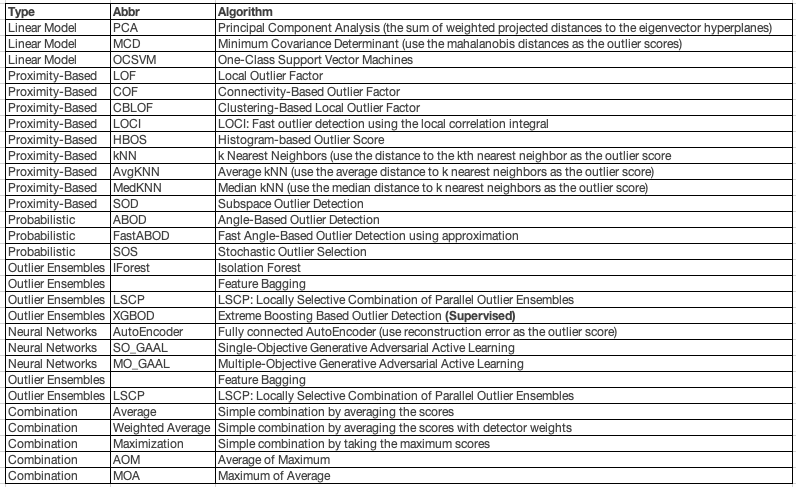